In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [716]:
import pandas as pd
import cv2
import glob
import pydicom
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import keras.backend as K
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Lambda, concatenate, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.losses import mean_squared_error
from keras.callbacks import ModelCheckpoint

In [4]:
PATH = "/home/jeff/notebooks/kaggle/pneumonia/"

In [9]:
df_labels = pd.read_csv('data/stage_1_train_labels.csv')

There are more than 1 bounding boxes per image

In [261]:
np.max(df_labels.groupby(['patientId']).size())

4

In [272]:
df_labels['patientId'].unique().shape

(25684,)

In [286]:
df_labels[['patientId','Target']].drop_duplicates().shape

(25684, 2)

Let's get the largest bounding box per image

In [301]:
df_labels['area'] = df_labels['width']*df_labels['height']

In [455]:
df_labels.groupby(['patientId','Target'])['area'].agg(np.max).reset_index().shape

(25684, 3)

In [432]:
df = pd.DataFrame(df_labels.groupby(['patientId','Target'])['area'].agg(np.max).reset_index())


In [433]:
print(df.shape)
df.head()

(25684, 3)


patientId  Target      area
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0       NaN
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd       0       NaN
2  00322d4d-1c29-4943-afc9-b6754be640eb       0       NaN
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5       0       NaN
4  00436515-870c-4b36-a041-de91049b9ab4       1  115968.0

In [434]:
assert(np.max(df.groupby(['patientId']).size())==1)

In [435]:
df.columns

Index(['patientId', 'Target', 'area'], dtype='object')

In [436]:
df_labels.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'area'], dtype='object')

In [445]:
df_merged = pd.merge(df, df_labels, on=['patientId','area'])


In [456]:
df_merged.head()

patientId  Target_x      area      x      y  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6         0       NaN    NaN    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd         0       NaN    NaN    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb         0       NaN    NaN    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5         0       NaN    NaN    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4         1  115968.0  562.0  152.0   

   width  height  Target_y  
0    NaN     NaN         0  
1    NaN     NaN         0  
2    NaN     NaN         0  
3    NaN     NaN         0  
4  256.0   453.0         1

In [448]:
df_merged.groupby('patientId').size().sort_values(ascending=False).head()

patientId
3db4f481-4e2e-4dd0-a191-a807ee22a39b    2
fffec09e-8a4a-48b1-b33e-ab4890ccd136    1
6a395564-08b0-431f-a97c-514c18b0949e    1
6a2d8b64-cf13-47e2-bed9-41a6b801e1fb    1
6a2e71ca-55a4-4b9e-ae97-a47a070fc89d    1
dtype: int64

In [457]:
df_merged.loc[df_merged['patientId'] == '3db4f481-4e2e-4dd0-a191-a807ee22a39b']

patientId  Target_x      area      x      y  \
3426  3db4f481-4e2e-4dd0-a191-a807ee22a39b         1  172215.0   77.0  179.0   
3427  3db4f481-4e2e-4dd0-a191-a807ee22a39b         1  172215.0  465.0  266.0   

      width  height  Target_y  
3426  267.0   645.0         1  
3427  267.0   645.0         1

In [462]:
df_merged = df_merged.drop(3427)

In [463]:
df_merged.shape

(25684, 8)

lets gut check that we got the largest by looking at one with multiple

In [359]:
df_labels.groupby(['patientId']).size().sort_values(ascending=False).head()

patientId
76f71a93-8105-4c79-a010-0cfa86f0061a    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
dtype: int64

In [363]:
np.asarray(df_labels)[np.where(df_labels['patientId'] == '76f71a93-8105-4c79-a010-0cfa86f0061a')]

array([['76f71a93-8105-4c79-a010-0cfa86f0061a', 619.0, 488.0, 127.0,
        155.0, 1, 19685.0],
       ['76f71a93-8105-4c79-a010-0cfa86f0061a', 673.0, 303.0, 106.0,
        145.0, 1, 15370.0],
       ['76f71a93-8105-4c79-a010-0cfa86f0061a', 314.0, 461.0, 91.0,
        128.0, 1, 11648.0],
       ['76f71a93-8105-4c79-a010-0cfa86f0061a', 348.0, 303.0, 81.0, 91.0,
        1, 7371.0]], dtype=object)

In [465]:
df_merged.loc[df_merged['patientId'] == '76f71a93-8105-4c79-a010-0cfa86f0061a']

patientId  Target_x     area      x      y  \
10079  76f71a93-8105-4c79-a010-0cfa86f0061a         1  19685.0  619.0  488.0   

       width  height  Target_y  
10079  127.0   155.0         1

In [468]:
df_merged = df_merged.reset_index()

In [505]:
df_merged[['patientId','x','y','width','height','Target_x']].head()

patientId      x      y  width  height  Target_x
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN         0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN         0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN         0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN         0
4  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0         1

In [669]:
df_merged['file_path'] = 'data/train/'+ df_merged['patientId']+'.dcm'

In [670]:
df_merged[['file_path','patientId','x','y','width','height','Target_x']].to_csv('data/train_max_bb_only.csv')

### Split the data

In [507]:
train_files = glob.glob('data/train/*.dcm')

In [508]:
len(train_files)

25684

In [10]:
df_labels = pd.read_csv('data/train_max_bb_only.csv')

In [11]:
N = df_labels.shape[0]
N

25684

In [30]:
validation_indexes = np.random.choice(np.arange(0,N), size=int(N/7))

In [31]:
len(validation_indexes)==int(N/7)

True

In [32]:
np.unique(validation_indexes).shape, int(N/7)

((3410,), 3669)

In [33]:
validation_indexes = np.unique(validation_indexes)

In [34]:
train_indexes = np.asarray([v for v in np.arange(0,N) if v not in validation_indexes])

In [35]:
train_indexes.shape[0]+ validation_indexes.shape[0]

25684

In [36]:
train_indexes

array([    0,     1,     2, ..., 25680, 25681, 25682])

In [37]:
validation_indexes

array([   18,    30,    47, ..., 25674, 25677, 25683])

In [38]:
train_df = pd.DataFrame(np.asarray(df_labels)[train_indexes])

In [39]:
valid_df = pd.DataFrame(np.asarray(df_labels)[validation_indexes])

In [40]:
valid_df.head()

0                                                  1  \
0  18  data/train/01027bc3-dc40-4165-a6c3-d6be2cb7ca3...   
1  30  data/train/01a4059c-22f7-4f51-8a27-50aff0b3aeb...   
2  47  data/train/01cfa23b-cc98-43af-a61b-56915f90b7e...   
3  53  data/train/01e4fd43-4f2c-421f-bd68-c756dceb574...   
4  56  data/train/01ef1712-90a6-4946-ad86-fc76b0cf2d3...   

                                      2    3    4    5    6  7  
0  01027bc3-dc40-4165-a6c3-d6be2cb7ca34  NaN  NaN  NaN  NaN  0  
1  01a4059c-22f7-4f51-8a27-50aff0b3aeb3  NaN  NaN  NaN  NaN  0  
2  01cfa23b-cc98-43af-a61b-56915f90b7ef  NaN  NaN  NaN  NaN  0  
3  01e4fd43-4f2c-421f-bd68-c756dceb5742  NaN  NaN  NaN  NaN  0  
4  01ef1712-90a6-4946-ad86-fc76b0cf2d3b  NaN  NaN  NaN  NaN  0

In [41]:
train_df.head()

0                                                  1  \
0  0  data/train/0004cfab-14fd-4e49-80ba-63a80b6bddd...   
1  1  data/train/00313ee0-9eaa-42f4-b0ab-c148ed3241c...   
2  2  data/train/00322d4d-1c29-4943-afc9-b6754be640e...   
3  3  data/train/003d8fa0-6bf1-40ed-b54c-ac657f8495c...   
4  4  data/train/00436515-870c-4b36-a041-de91049b9ab...   

                                      2    3    4    5    6  7  
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  NaN  NaN  NaN  NaN  0  
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  NaN  NaN  NaN  NaN  0  
2  00322d4d-1c29-4943-afc9-b6754be640eb  NaN  NaN  NaN  NaN  0  
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  NaN  NaN  NaN  NaN  0  
4  00436515-870c-4b36-a041-de91049b9ab4  562  152  256  453  1

In [42]:
np.where(df_labels['Target_x']==0)[0].shape, np.where(df_labels['Target_x']==1)[0].shape

((20025,), (5659,))

In [43]:
np.where(df_labels['Target_x']==0)[0].shape[0]/np.where(df_labels['Target_x']==1)[0].shape[0]

3.5386110620250926

In [44]:
np.where(valid_df[7]==0)[0].shape, np.where(valid_df[7]==1)[0].shape

((2656,), (754,))

In [45]:
np.where(valid_df[7]==0)[0].shape[0]/ np.where(valid_df[7]==1)[0].shape[0]

3.522546419098143

In [46]:
np.where(train_df[7]==0)[0].shape, np.where(train_df[7]==1)[0].shape

((17369,), (4905,))

In [47]:
np.where(train_df[7]==0)[0].shape[0]/ np.where(train_df[7]==1)[0].shape[0]

3.5410805300713557

In [48]:
train_df.to_csv('train_df.csv')
valid_df.to_csv('valid_df.csv')

In [30]:
train_df = pd.read_csv('train_df.csv', index_col=0, names=[i for i in range(8)], header=0)
valid_df = pd.read_csv('valid_df.csv', index_col=0, names=[i for i in range(8)], header=0)

In [31]:
train_df.head()

0                                                  1  \
0  0  data/train/0004cfab-14fd-4e49-80ba-63a80b6bddd...   
1  1  data/train/00313ee0-9eaa-42f4-b0ab-c148ed3241c...   
2  2  data/train/00322d4d-1c29-4943-afc9-b6754be640e...   
3  3  data/train/003d8fa0-6bf1-40ed-b54c-ac657f8495c...   
4  4  data/train/00436515-870c-4b36-a041-de91049b9ab...   

                                      2      3      4      5      6  7  
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN    NaN  0  
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN    NaN  0  
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN    NaN  0  
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN    NaN  0  
4  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0  453.0  1

### Create Data Loader

- https://keras.io/preprocessing/image/

We need something that will yield a batch of images and labels one at a time

For example: we might have a class that accepts a list of files and their targets, batchsize, and a boolean (random true/false)

In [1177]:
class CustomImageDataLoader():
    def __init__(self, file_paths, targets, sz=256, bs=64, channels=1, shuffle=False,
                tfm=None):
        """
        args:
         - file_paths: iterable of file paths (ie. array or list)
         - targets: np.array of targets (order should correspond with the correct input file)
         - sz: image size
         - bs: batch size
         - channels: number of image channels (ie. 1 or 3)
         - shuffle: whether or not to shuffle the data
         - tfm: a function to apply to the images and targets the function 
           signature should be prepared to receive an image and a target
           and should return a transformed image and target
        """
        self.N = len(file_paths)
        self.file_paths = file_paths
        self.sz = sz
        self.bs = bs
        self.shuffle = shuffle
        self.channels = channels
        self.all_targets = targets
        self.tfm = tfm
        self.inputs = np.zeros((self.bs, self.sz, self.sz, self.channels))
        self.targets = np.zeros((self.bs,)+targets.shape[1:])
        self.total_batches = math.ceil(self.N/self.bs)
        self.reset()
        
    def reset(self):
        self.batch_index = 0
        self.order = np.random.permutation(self.N) if self.shuffle else np.arange(self.N)
        
    @hack
    def next(self):
        bs = self.bs if self.batch_index < self.total_batches-1 or not self.N%self.bs else self.N%self.bs
        offset = self.batch_index*self.bs
        for i in range(bs):
            idx = self.order[offset + i]
            dicom_im = pydicom.dcmread(self.file_paths[idx])
            if self.tfm:
                self.inputs[i], self.targets[i] = self.tfm(
                            np.expand_dims( cv2.resize(dicom_im.pixel_array, (self.sz,self.sz)), -1),
                            self.all_targets[idx]#.copy()
                )
            else:
                self.inputs[i] = np.expand_dims( cv2.resize(dicom_im.pixel_array, (self.sz,self.sz)), -1)
                self.targets[i] = self.all_targets[idx]
        self.batch_index += 1
        if self.batch_index == self.total_batches: self.reset()
        return self.inputs[:bs], self.targets[:bs]
    
    def __iter__(self): return self

    def __next__(self, *args, **kwargs): return self.next(*args, **kwargs)

### Quick test of the data loader with a small subset of the data

In [35]:
dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=3)

In [36]:
x,y = next(dl)
x.shape, y.shape

((3, 256, 256, 1), (3,))

In [37]:
x,y = next(dl)
x,y = next(dl)
x,y = next(dl)
x.shape, y.shape

((1, 256, 256, 1), (1,))

In [38]:
x,y = next(dl)
x.shape, y.shape

((3, 256, 256, 1), (3,))

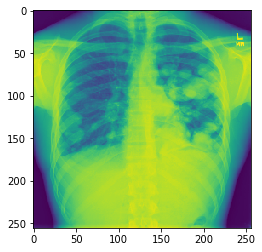

In [896]:
plt.imshow(np.squeeze(x[2]))

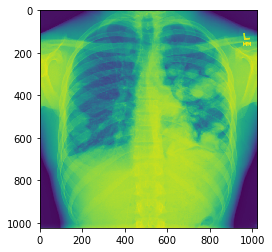

In [897]:
plt.imshow(pydicom.dcmread(train_df[1][2]).pixel_array)

In [898]:
dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=3, shuffle=True)

In [899]:
x,y = next(dl)
x.shape, y.shape

((3, 256, 256, 1), (3,))

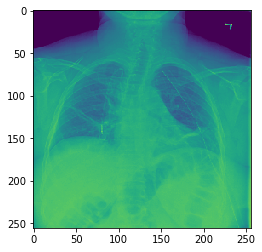

In [900]:
plt.imshow(np.squeeze(x[2])) #this will likely be a different image since we shuffled the data

In [901]:
train_df.head()

0                                                  1  \
0  0  data/train/0004cfab-14fd-4e49-80ba-63a80b6bddd...   
1  1  data/train/00313ee0-9eaa-42f4-b0ab-c148ed3241c...   
2  2  data/train/00322d4d-1c29-4943-afc9-b6754be640e...   
3  3  data/train/003d8fa0-6bf1-40ed-b54c-ac657f8495c...   
4  4  data/train/00436515-870c-4b36-a041-de91049b9ab...   

                                      2    3    4    5    6  7  
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  NaN  NaN  NaN  NaN  0  
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  NaN  NaN  NaN  NaN  0  
2  00322d4d-1c29-4943-afc9-b6754be640eb  NaN  NaN  NaN  NaN  0  
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  NaN  NaN  NaN  NaN  0  
4  00436515-870c-4b36-a041-de91049b9ab4  562  152  256  453  1

In [902]:
train_df[1][4]

'data/train/00436515-870c-4b36-a041-de91049b9ab4.dcm'

In [903]:
im = pydicom.dcmread(train_df[1][4]).pixel_array

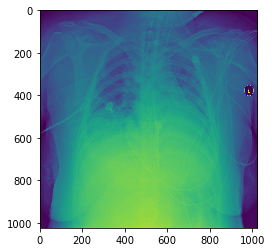

In [904]:
plt.imshow(im)

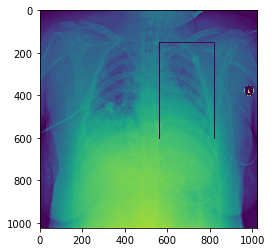

In [905]:
x1 = 562
y1 = 152
x2 = x1 + 256
y2 = y1 + 453
plt.imshow(cv2.rectangle(im, (x1, y1), (x2, y2), (0,255,255), 2))

### Dataloader with x,y,width,height,class targets

In [154]:
im = cv2.resize(pydicom.dcmread(train_df[1][4]).pixel_array,(256,256))

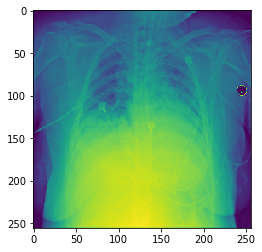

In [155]:
plt.imshow(im)

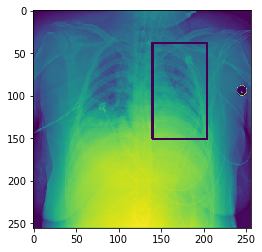

In [156]:
x1 = int(562/4)
y1 = int(152/4)
x2 = x1 + int(256/4)
y2 = y1 + int(453/4)
plt.imshow(cv2.rectangle(im, (x1, y1), (x2, y2), (0,255,255), 2))

In [172]:
targets = np.asarray(train_df[[3,4,5,6,7]][:10]) #x,y,width,height,class

In [173]:
targets[:,:4] = targets[:,:4]//4 #resize targets since image size is 256 instead of 1024

In [174]:
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3)

In [175]:
x,y = next(dl)
x,y = next(dl)

In [176]:
y[1]

array([140.,  38.,  64., 113.,   1.])

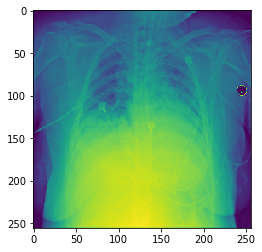

In [177]:
plt.imshow(np.squeeze(x[1]))

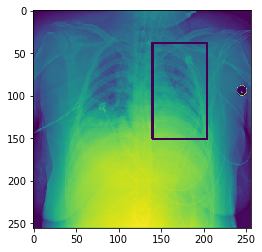

In [178]:
plt.imshow(
    cv2.rectangle(np.squeeze(x[1]), 
                  (int(y[1][0]), int(y[1][1])), 
                  (int(y[1][0]+y[1][2]), int(y[1][1]+y[1][3])), 
                  (0,255,255), 
                  2
    )
)

We are going to create a data loader that flips the images and targets randomly

In [1178]:
class Transform:

    @staticmethod
    def horizontal_flip(x, y):
        if len(y.shape) and y.shape[0] > 1: y[0] = 256 - y[0] - y[2]
        return np.flip(x, axis=1), y

    @staticmethod
    def vertical_flip(x, y):
        if len(y.shape) and y.shape[0] > 1: y[1] = 256 - y[1] - y[3]
        return np.flip(x, axis=0), y

    @staticmethod
    def rotate(im, y, deg, mode=cv2.BORDER_CONSTANT, interpolation=cv2.INTER_AREA):
        """ Inspired by fasti.ai's rotate function:
        https://github.com/fastai/fastai/blob/74da9714ac936daf649451dafd7c882b9307a1ea/old/fastai/transforms.py
        
        Rotate an image by deg degrees
        Arguments:
            im: image to rotate
            y: bbox (x,y,w,h)
            deg (float): degree to rotate.
        """
        r,c,*_ = im.shape
        M = cv2.getRotationMatrix2D((c//2,r//2), deg, 1)
        if len(y.shape) and y.shape[0] > 1 and not np.all(np.isnan(y[:4])):
            #make a rectangle
            y = y.astype('int')
            y1 = np.zeros((r, c))
            y1[y[1]:y[1]+y[3],y[0]:y[0]+y[2]] = 1
            #calc new bbox
            y1_rot = cv2.warpAffine(y1,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)
            ys,xs = np.where(y1_rot)
            x0, y0, x1, y1 = np.min(xs), np.min(ys), np.max(xs), np.max(ys)
            y[:4] = np.array([x0,y0,x1-x0,y1-y0])
        return np.expand_dims(cv2.warpAffine(im,M,(c,r), 
                                             borderMode=mode, 
                                             flags=cv2.WARP_FILL_OUTLIERS+interpolation),-1), y

    def __call__(self, x,y):
        if np.random.randint(0,2):
            x,y = self.horizontal_flip(x,y)
        if np.random.randint(0,2):
            x,y = self.vertical_flip(x,y)
        x,y = self.rotate(x, y, np.random.randint(-25,25))
        return x,y

In [1108]:
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3, tfm=Transform.horizontal_flip)

In [1124]:
tfm = Transform()
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3, tfm=tfm)

In [1125]:
x,y = next(dl)
x,y = next(dl)

In [1126]:
y[1]

array([ 39.,  93.,  80., 121.,   1.])

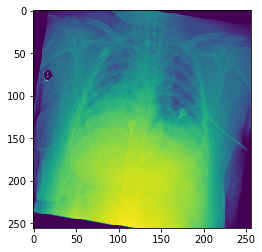

In [1127]:
plt.imshow(np.squeeze(x[1]))

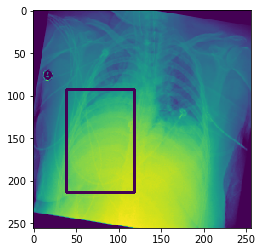

In [1128]:
plt.imshow(
    cv2.rectangle(np.squeeze(x[1]),
                  (int(y[1][0]), int(y[1][1])),
                  (int(y[1][0]+y[1][2]), int(y[1][1]+y[1][3])),
                  (0,255,255),
                  2
    )
)

a quick hack to get multiple targets into the format keras expects

In [1171]:
from functools import wraps

def hack(f):
    @wraps(f)
    def wrapper(*args,**kwargs):
        x,y = f(*args,**kwargs)
        return x, [y[:,:4], y[:,-1]]
    return wrapper

In [142]:
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3, tfm=Transform.horizontal_flip)

NameError: name 'targets' is not defined

In [1065]:
tfm = Transform()
dl = CustomImageDataLoader(train_df[1][:10], targets, bs=3, tfm=tfm)

In [1066]:
x,y = next(dl)
x,y = next(dl)

In [1067]:
y

[array([[ nan,  nan,  nan,  nan],
        [ 52., 105.,  64., 113.],
        [ nan,  nan,  nan,  nan]]), array([0., 1., 0.])]

In [1074]:
y[0][0][0]

nan

### Create Model Architecture

In [163]:
n = int(1024/2)

input_layer = Input((256,256,1))
c1 = Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu')(input_layer)
b1 = BatchNormalization()(c1)
c2 = Conv2D(48, kernel_size=(5,5), strides=(2,2),activation='relu')(b1)
b2 = BatchNormalization()(c2)
c3 = Conv2D(64, kernel_size=(5,5), strides=(2,2),activation='relu')(b2)
b3 = BatchNormalization()(c3)
# c4 = Conv2D(128, kernel_size=(3,3), activation='relu')(c3)
a = MaxPooling2D(pool_size=(7,7),name='maxpool')(b3)
b = AveragePooling2D(pool_size=(7,7),name='avgpool')(c3)
x = concatenate([a,b], axis = -1)
flat = Flatten()(x)
d1 = Dense(n, activation='relu')(flat)
d2 = Dense(int(n/2), activation='relu')(d1)
d3 = Dense(int(n/4), activation='relu')(d2)
out = Dense(1, activation='sigmoid')(d3)
model = Model(inputs=input_layer, outputs= [out])

In [164]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 126, 126, 24) 624         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 126, 126, 24) 96          conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 61, 61, 48)   28848       batch_normalization_7[0][0]      
__________________________________________________________________________________________________
batch_norm

In [167]:
model.compile('adam', 'binary_crossentropy', metrics=['acc'])

### Train Classification Model

In [168]:
dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=3)

In [169]:
x,y = next(dl)

It is always a good idea to do a quick gut check with a subset of the data

In [171]:
bs = 64
epochs = 1
train_N = 10 #dataset size
valid_N = 10
train_dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=bs)
valid_dl = CustomImageDataLoader(valid_df[1][:10], valid_df[7][:10], bs=bs)

In [172]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = 1
)

Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 1.1549 - acc: 0.2000 - val_loss: 2.5698 - val_acc: 0.8000


And now training!

In [173]:
bs = 64
epochs = 5
train_N = len(train_df) #dataset size
valid_N = len(valid_df)
train_dl = CustomImageDataLoader(train_df[1], train_df[7], bs=bs)
valid_dl = CustomImageDataLoader(valid_df[1], valid_df[7], bs=bs)

In [174]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

Epoch 1/5
349/349 [==============================] - 132s 378ms/step - loss: 0.4279 - acc: 0.8156 - val_loss: 0.4399 - val_acc: 0.8293
Epoch 2/5
349/349 [==============================] - 128s 367ms/step - loss: 0.3983 - acc: 0.8236 - val_loss: 0.4104 - val_acc: 0.8287
Epoch 3/5
349/349 [==============================] - 128s 368ms/step - loss: 0.3926 - acc: 0.8278 - val_loss: 0.4046 - val_acc: 0.8290
Epoch 4/5
349/349 [==============================] - 128s 367ms/step - loss: 0.3939 - acc: 0.8267 - val_loss: 0.4147 - val_acc: 0.8337
Epoch 5/5
349/349 [==============================] - 128s 368ms/step - loss: 0.3855 - acc: 0.8288 - val_loss: 0.4142 - val_acc: 0.8282


In [183]:
model.save('models/binary_classification.hd5')

In [175]:
x,y = next(train_dl)

In [176]:
x.shape, y.shape

((64, 256, 256, 1), (64,))

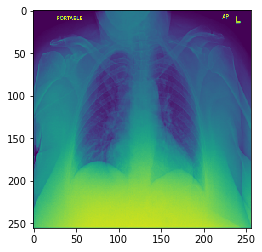

In [177]:
plt.imshow(np.squeeze(x[0]))

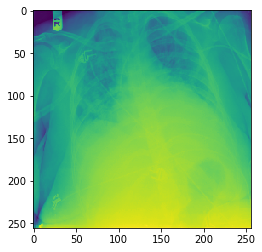

In [178]:
plt.imshow(np.squeeze(x[1]))

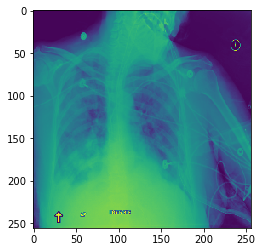

In [179]:
plt.imshow(np.squeeze(x[2]))

In [180]:
y[:10]

array([0., 1., 1., 0., 0., 1., 1., 0., 0., 0.])

In [181]:
out = model.predict(x)

In [182]:
out[:10]

array([[0.05554798],
       [0.56735057],
       [0.14210807],
       [0.09187744],
       [0.01055479],
       [0.06737858],
       [0.5297102 ],
       [0.21324702],
       [0.31150967],
       [0.01152845],
       [0.00491317],
       [0.03794318],
       [0.07318751],
       [0.01434659],
       [0.01755332],
       [0.01783291],
       [0.23792993],
       [0.28184736],
       [0.05274992],
       [0.03429569],
       [0.12533876],
       [0.14046182],
       [0.03213091],
       [0.02741813],
       [0.12941955],
       [0.02227198],
       [0.01541772],
       [0.1237431 ],
       [0.02905994],
       [0.01498801],
       [0.2910867 ],
       [0.04834596],
       [0.528621  ],
       [0.01304008],
       [0.07708725],
       [0.1386741 ],
       [0.31782964],
       [0.02488949],
       [0.5846604 ],
       [0.10516305],
       [0.08542844],
       [0.37408012],
       [0.04455635],
       [0.02018391],
       [0.06430413],
       [0.01229032],
       [0.01843928],
       [0.038

### Train Classification Model with Data augmentation

In [41]:
model = load_model('models/binary_classification.hd5')

In [99]:
tfm = Transform()

It is always a good idea to do a quick gut check with a subset of the data

In [108]:
bs = 64
epochs = 1
train_N = 10 #dataset size
valid_N = 10
train_dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=bs, tfm=tfm)
valid_dl = CustomImageDataLoader(valid_df[1][:10], valid_df[7][:10], bs=bs)

In [105]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = 1
)

Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.3275 - acc: 0.8000 - val_loss: 0.1960 - val_acc: 0.9000


And now training!

In [109]:
bs = 64
epochs = 5
train_N = len(train_df) #dataset size
valid_N = len(valid_df)
train_dl = CustomImageDataLoader(train_df[1], train_df[7], bs=bs, tfm=tfm)
valid_dl = CustomImageDataLoader(valid_df[1], valid_df[7], bs=bs)

In [110]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

Epoch 1/5
349/349 [==============================] - 143s 409ms/step - loss: 0.4010 - acc: 0.8236 - val_loss: 0.4140 - val_acc: 0.8314
Epoch 2/5
349/349 [==============================] - 128s 366ms/step - loss: 0.3949 - acc: 0.8261 - val_loss: 0.4071 - val_acc: 0.8264
Epoch 3/5
349/349 [==============================] - 128s 366ms/step - loss: 0.3930 - acc: 0.8282 - val_loss: 0.4208 - val_acc: 0.8276
Epoch 4/5
349/349 [==============================] - 128s 367ms/step - loss: 0.3903 - acc: 0.8267 - val_loss: 0.4304 - val_acc: 0.8132
Epoch 5/5
349/349 [==============================] - 128s 366ms/step - loss: 0.3879 - acc: 0.8311 - val_loss: 0.4125 - val_acc: 0.8311


In [111]:
model.save('models/binary_classification_w_aug.hd5')

### Bounding Box Prediction/Localization

Let's load in the model we already used for classification. We will modify it to predict bounding boxes.

In [639]:
model = load_model('models/binary_classification_w_aug.hd5')

In [640]:
model.layers

We need to replace the final layers of the model. We don't want the Max or Average pooling so let's remove those. We also need to predict four scalers representing our bounding box.

In [641]:
input_layer = model.input
middle_layer = model.layers[6].output
c4 = Conv2D(128, kernel_size=(5,5), strides=(2,2), activation='relu')(middle_layer)
flat = Flatten()(c4)
drop = Dropout(.25)(flat) #new
d1 = Dense(256, activation='relu')(drop)
b4 = BatchNormalization()(d1)
out = Dense(4, activation='linear')(b4)

In [642]:
model = Model(inputs=model.input, outputs= [out])

We will use mean squared error to calculate loss

In [643]:
model.compile('adam', mean_squared_error, metrics=['acc'])

For now we are going to ignore the category and simply predict a bounding box. We are also going to ignore all the non-pneumonia patients for now.  Don't worry we will combine what we have learned in a later step.

In [644]:
train_targets = np.asarray(train_df[[3,4,5,6]]) #x,y,width,height
valid_targets = np.asarray(valid_df[[3,4,5,6]]) #x,y,width,height

In [645]:
train_idx=np.where(np.all(np.isnan(train_targets),axis=-1)==False)
valid_idx=np.where(np.all(np.isnan(valid_targets),axis=-1)==False)

In [646]:
len(train_idx[0]), len(valid_idx[0])

(4905, 754)

In [647]:
train_targets = train_targets[train_idx]
valid_targets = valid_targets[valid_idx]

In [648]:
train_targets[:,:4] = train_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024
valid_targets[:,:4] = valid_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024

And now training!

In [649]:
bs = 64
epochs = 5
train_N = len(train_targets) #dataset size
valid_N = len(valid_targets)
train_dl = CustomImageDataLoader(np.asarray(train_df[1])[train_idx], 
                                 train_targets, bs=bs, tfm=tfm, shuffle=True)
valid_dl = CustomImageDataLoader(np.asarray(valid_df[1])[valid_idx], 
                                 valid_targets, bs=bs)

In [650]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

Epoch 1/5
77/77 [==============================] - 27s 347ms/step - loss: 7968.9028 - acc: 0.4888 - val_loss: 9881.1912 - val_acc: 0.4390
Epoch 2/5
77/77 [==============================] - 26s 332ms/step - loss: 7438.6343 - acc: 0.3905 - val_loss: 7860.6088 - val_acc: 0.3820
Epoch 3/5
77/77 [==============================] - 26s 334ms/step - loss: 5820.0227 - acc: 0.3678 - val_loss: 4981.9576 - val_acc: 0.3554
Epoch 4/5
77/77 [==============================] - 26s 333ms/step - loss: 3903.6164 - acc: 0.3775 - val_loss: 3688.6841 - val_acc: 0.3886
Epoch 5/5
77/77 [==============================] - 26s 335ms/step - loss: 2418.6397 - acc: 0.3858 - val_loss: 2115.7745 - val_acc: 0.4244


In [477]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    #b x,y,width,height
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [736]:
x,y = next(valid_dl)

In [655]:
preds = model.predict(x)

The white boxes are the ground truth and the blue boxes are our predictions

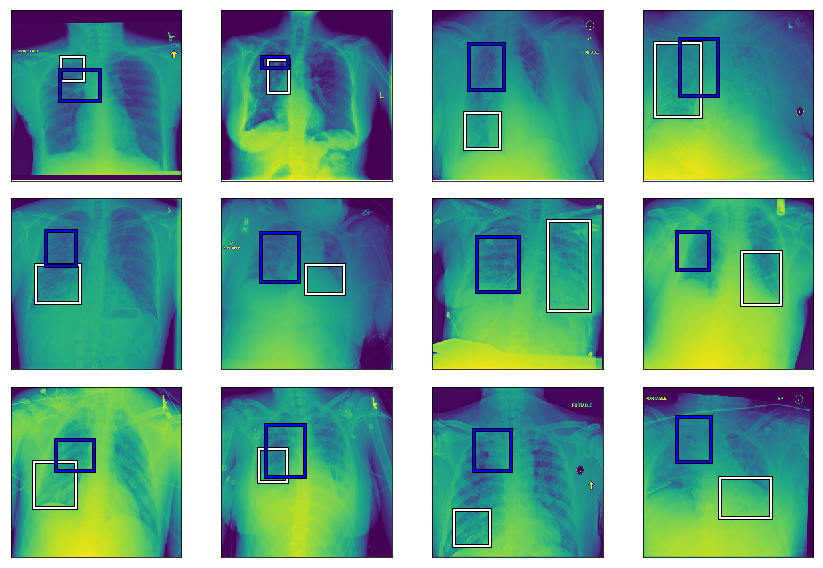

In [656]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ax = show_img(np.squeeze(x[i]), ax=ax)
    draw_rect(ax, y[i])
    draw_rect(ax, preds[i], color='blue')
plt.tight_layout()

In [657]:
model.save('models/bbox_w_aug.hd5')

In [615]:
model = load_model('models/bbox_w_aug.hd5')

### binary_classification and localization

In [1166]:
model = load_model('models/bbox_w_aug.hd5')

In [1167]:
model.layers

In [1168]:
bn = model.layers[-2].output
class_out = Dense(1, activation='sigmoid', name="class_out")(bn)
bbox_out = model.layers[-1].output
model.layers[-1].name = "bbox_out"
model = Model(inputs=[model.input], outputs=[bbox_out, class_out])

In [1184]:
loss_weights = {"bbox_out": 1.0, "class_out": 3000.0}
less_funcs = {"bbox_out": mean_squared_error_no_nan, "class_out":"binary_crossentropy"}
model.compile(optimizer='adam', loss=less_funcs, loss_weights=loss_weights, metrics={"class_out":["acc"]})

In [1171]:
from functools import wraps

def hack(f):
    @wraps(f)
    def wrapper(*args,**kwargs):
        x,y = f(*args,**kwargs)
        return x, [y[:,:4], y[:,-1]]
    return wrapper

In [1179]:
train_targets = np.asarray(train_df[[3,4,5,6,7]]) #x,y,width,height
valid_targets = np.asarray(valid_df[[3,4,5,6,7]]) #x,y,width,height

In [1180]:
train_targets[:,:4] = train_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024
valid_targets[:,:4] = valid_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024

And now training!

In [1181]:
bs = 64
epochs = 5
train_N = len(train_df) #dataset size
valid_N = len(valid_df)
train_dl = CustomImageDataLoader(train_df[1], train_targets, bs=bs, tfm=tfm, shuffle=True)
valid_dl = CustomImageDataLoader(valid_df[1], valid_targets, bs=bs)

In [1185]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

/home/jeff/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
349/349 [==============================] - 144s 413ms/step - loss: 2722.2983 - bbox_out_loss: 1404.8223 - class_out_loss: 0.4392 - class_out_acc: 0.8012 - val_loss: 2773.1558 - val_bbox_out_loss: 1403.7526 - val_class_out_loss: 0.4565 - val_class_out_acc: 0.7906
Epoch 2/5
349/349 [==============================] - 140s 400ms/step - loss: 2712.9885 - bbox_out_loss: 1444.6626 - class_out_loss: 0.4228 - class_out_acc: 0.8093 - val_loss: 3176.3962 - val_bbox_out_loss: 1534.3961 - val_class_out_loss: 0.5473 - val_class_out_acc: 0.7713
Epoch 3/5
349/349 [==============================] - 140s 402ms/step - loss: nan - bbox_out_loss: nan - class_out_loss: 0.4126 - class_out_acc: 0.8140 - val_loss: 2729.7010 - val_bbox_out_loss: 1360.5147 - val_class_out_loss: 0.4564 - val_class_out_acc: 0.8015
Epoch 4/5
349/349 [==============================] - 140s 401ms/step - loss: 2609.6704 - bbox_out_loss: 1384.6337 - class_out_loss: 0.4083 - class_out_acc: 0.8166 - val_loss: 2651.8771 - val_bb

In [1186]:
model.save('models/bbox_and_class_w_aug.hd5')

In [1187]:
x,y = next(valid_dl)

In [1188]:
preds = model.predict(x)

In [1194]:
box_idx=np.where(np.all(np.isnan(y[0]),axis=-1)==False)

In [1197]:
len(box_idx[0])

9

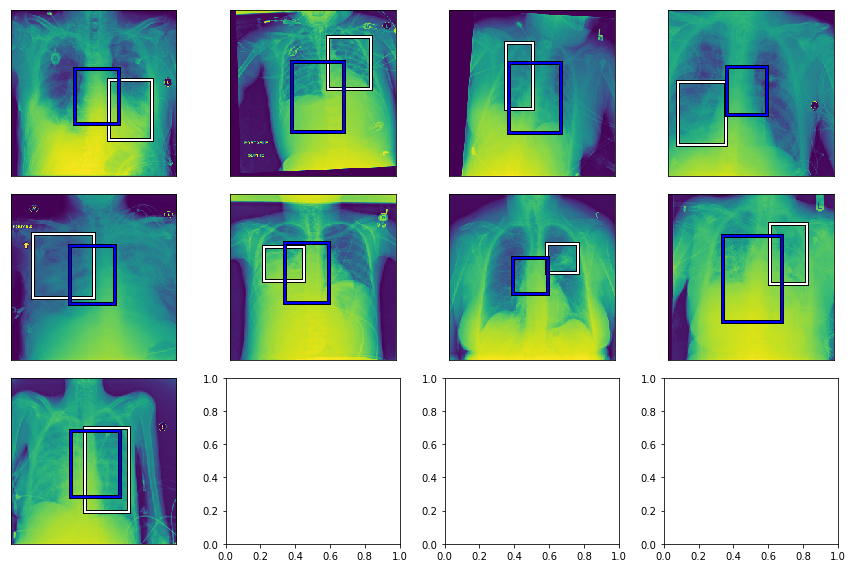

In [1198]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    if i < len(box_idx[0]):
        ax = show_img(np.squeeze(x[box_idx][i]), ax=ax)
        draw_rect(ax, y[0][box_idx][i])
        draw_rect(ax, preds[0][box_idx][i], color='blue')
plt.tight_layout()

### Next Steps

Things to try:
 - More complex/advanced network architecture
   - This did slightly better, but still predicting mainly in the center of the image
 - Train only on the images w/ bboxes
   - This somewhat fixed the problem
 - Concatenating channels with pixel positions to the input image
   - This helped a little maybe?
 - More data augmentation
   - Didn't hurt, seemed to help some
 - Make the targets top right and bottom left corner instead of top left (x,y), width, and height
 - Use anchors to predict multiple boxes
 - U-net w/ thresholding plus peak finding to recreate the bbox

#### More aug (Rotation)

In [1129]:
model = load_model('models/binary_classification_w_aug.hd5')

We need to replace the final layers of the model. We don't want the Max or Average pooling so let's remove those. We also need to predict four scalers representing our bounding box.

In [1130]:
input_layer = model.input
middle_layer = model.layers[6].output
c4 = Conv2D(128, kernel_size=(5,5), strides=(2,2), activation='relu')(middle_layer)
flat = Flatten()(c4)
drop = Dropout(.25)(flat) #new
d1 = Dense(256, activation='relu')(drop)
b4 = BatchNormalization()(d1)
out = Dense(4, activation='linear')(b4)

In [1131]:
model = Model(inputs=model.input, outputs= [out])

We will use mean squared error to calculate loss

In [1132]:
model.compile('adam', mean_squared_error, metrics=['acc'])

For now we are going to ignore the category and simply predict a bounding box. We are also going to ignore all the non-pneumonia patients for now.  Don't worry we will combine what we have learned in a later step.

In [1133]:
train_targets = np.asarray(train_df[[3,4,5,6]]) #x,y,width,height
valid_targets = np.asarray(valid_df[[3,4,5,6]]) #x,y,width,height

In [1134]:
train_idx=np.where(np.all(np.isnan(train_targets),axis=-1)==False)
valid_idx=np.where(np.all(np.isnan(valid_targets),axis=-1)==False)

In [1135]:
len(train_idx[0]), len(valid_idx[0])

(4905, 754)

In [1136]:
train_targets = train_targets[train_idx]
valid_targets = valid_targets[valid_idx]

In [1137]:
train_targets[:,:4] = train_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024
valid_targets[:,:4] = valid_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024

And now training!

In [1138]:
bs = 64
epochs = 5
train_N = len(train_targets) #dataset size
valid_N = len(valid_targets)
train_dl = CustomImageDataLoader(np.asarray(train_df[1])[train_idx], 
                                 train_targets, bs=bs, tfm=tfm, shuffle=True)
valid_dl = CustomImageDataLoader(np.asarray(valid_df[1])[valid_idx], 
                                 valid_targets, bs=bs)

In [1139]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

Epoch 1/5
77/77 [==============================] - 32s 414ms/step - loss: 8384.2272 - acc: 0.4910 - val_loss: 8380.6304 - val_acc: 0.5186
Epoch 2/5
77/77 [==============================] - 30s 396ms/step - loss: 7828.5190 - acc: 0.4126 - val_loss: 8616.1713 - val_acc: 0.2560
Epoch 3/5
77/77 [==============================] - 31s 397ms/step - loss: 6186.0167 - acc: 0.4051 - val_loss: 6377.8703 - val_acc: 0.3103
Epoch 4/5
77/77 [==============================] - 30s 396ms/step - loss: 4166.9984 - acc: 0.3931 - val_loss: 3120.7505 - val_acc: 0.4695
Epoch 5/5
77/77 [==============================] - 30s 395ms/step - loss: 2548.9885 - acc: 0.4019 - val_loss: 2636.8180 - val_acc: 0.4390


In [1140]:
x,y = next(valid_dl)

In [1141]:
preds = model.predict(x)

The white boxes are the ground truth and the blue boxes are our predictions

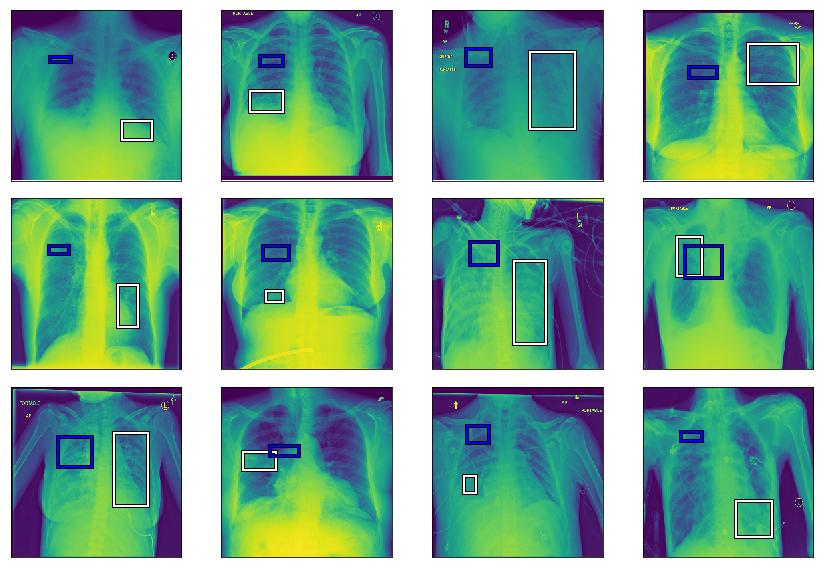

In [1142]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ax = show_img(np.squeeze(x[i]), ax=ax)
    draw_rect(ax, y[i])
    draw_rect(ax, preds[i], color='blue')
plt.tight_layout()

In [1143]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

Epoch 1/5
77/77 [==============================] - 31s 407ms/step - loss: 1762.0489 - acc: 0.4200 - val_loss: 1815.5008 - val_acc: 0.2825
Epoch 2/5
77/77 [==============================] - 31s 398ms/step - loss: 1471.6244 - acc: 0.4502 - val_loss: 1747.3730 - val_acc: 0.4244
Epoch 3/5
77/77 [==============================] - 30s 396ms/step - loss: 1420.1234 - acc: 0.4500 - val_loss: 1658.3395 - val_acc: 0.3647
Epoch 4/5
77/77 [==============================] - 31s 397ms/step - loss: 1396.4377 - acc: 0.4702 - val_loss: 2187.2789 - val_acc: 0.2294
Epoch 5/5
77/77 [==============================] - 31s 396ms/step - loss: 1387.5877 - acc: 0.4715 - val_loss: 1516.6060 - val_acc: 0.4509


In [1144]:
x,y = next(valid_dl)

In [1145]:
preds = model.predict(x)

The white boxes are the ground truth and the blue boxes are our predictions

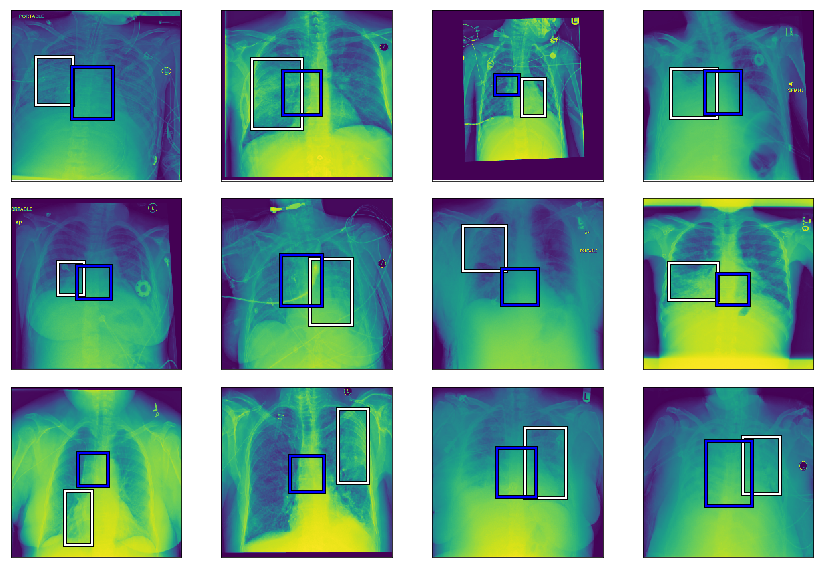

In [1146]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ax = show_img(np.squeeze(x[i]), ax=ax)
    draw_rect(ax, y[i])
    draw_rect(ax, preds[i], color='blue')
plt.tight_layout()

#### Concatenating channels with pixel positions to the input image

In [859]:
a = K.eval( tf.tile( tf.reshape(K.arange(0,256),[-1,1]), [1,256]) )
b = K.eval( tf.tile( tf.reshape(K.arange(0,256),[1,-1]), [256,1]) )

In [889]:
a = tf.tile( tf.reshape(K.arange(0,256),[-1,1]), [1,256])
a = K.expand_dims(tf.tile( tf.reshape(a, [1,256,256]), [64,1,1]),-1)
b = tf.tile( tf.reshape(K.arange(0,256),[1,-1]), [256,1])
b = K.expand_dims(tf.tile( tf.reshape(b, [1,256,256]), [64,1,1]),-1)
c = K.eval( K.concatenate([a,b],-1))

In [891]:
c[0,:10,:10,0], c[0,:10,:10,1]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]], dtype=int32),
 array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], dtype=int32))

In [894]:
def add_spacial_context(x):
    bs = K.shape(x)[0]
    sz = x.get_shape().as_list()[1]
    a = tf.tile( tf.reshape(K.arange(0,sz),[-1,1]), [1,sz])
    a = K.cast(K.expand_dims(tf.tile( tf.reshape(a, [1,sz,sz]), [bs,1,1]),-1), dtype='float32')
    b = tf.tile( tf.reshape(K.arange(0,sz),[1,-1]), [sz,1])
    b = K.cast(K.expand_dims(tf.tile( tf.reshape(b, [1,sz,sz]), [bs,1,1]),-1), dtype='float32')
    return K.concatenate([x,a,b],-1)

def add_spacial_context_shape(input_shape):
    shape = list(input_shape)
    assert(len(shape)==4)
    shape[-1]+=2
    return shape

In [895]:

input_layer = Input((256,256,1))
input_mod = Lambda(add_spacial_context, output_shape=add_spacial_context_shape)(input_layer)
c1 = Conv2D(24, kernel_size=(5,5), strides=(2,2), activation='relu')(input_mod)
b1 = BatchNormalization()(c1)
c2 = Conv2D(48, kernel_size=(5,5), strides=(2,2),activation='relu')(b1)
b2 = BatchNormalization()(c2)
c3 = Conv2D(64, kernel_size=(5,5), strides=(2,2),activation='relu')(b2)
b3 = BatchNormalization()(c3)
c4 = Conv2D(128, kernel_size=(5,5), strides=(2,2), activation='relu')(b3)
flat = Flatten()(c4)
drop = Dropout(.25)(flat) #new
d1 = Dense(256, activation='relu')(drop)
b4 = BatchNormalization()(d1)
out = Dense(4, activation='linear')(b4)

In [896]:
model = Model(inputs=[input_layer], outputs=[out])

In [897]:
model.compile('adam', mean_squared_error)

In [898]:
train_targets = np.asarray(train_df[[3,4,5,6]]) #x,y,width,height
valid_targets = np.asarray(valid_df[[3,4,5,6]]) #x,y,width,height

In [899]:
train_idx=np.where(np.all(np.isnan(train_targets),axis=-1)==False)
valid_idx=np.where(np.all(np.isnan(valid_targets),axis=-1)==False)

In [900]:
len(train_idx[0]), len(valid_idx[0])

(4905, 754)

In [901]:
train_targets = train_targets[train_idx]
valid_targets = valid_targets[valid_idx]

In [902]:
train_targets[:,:4] = train_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024
valid_targets[:,:4] = valid_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024

And now training!

In [903]:
bs = 64
epochs = 5
train_N = len(train_targets) #dataset size
valid_N = len(valid_targets)
train_dl = CustomImageDataLoader(np.asarray(train_df[1])[train_idx], 
                                 train_targets, bs=bs, tfm=tfm, shuffle=True)
valid_dl = CustomImageDataLoader(np.asarray(valid_df[1])[valid_idx], 
                                 valid_targets, bs=bs)

In [904]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

Epoch 1/5
77/77 [==============================] - 28s 364ms/step - loss: 8051.3642 - val_loss: 7249.4742
Epoch 2/5
77/77 [==============================] - 27s 345ms/step - loss: 7465.3111 - val_loss: 7177.5767
Epoch 3/5
77/77 [==============================] - 27s 346ms/step - loss: 5922.0466 - val_loss: 4882.6993
Epoch 4/5
77/77 [==============================] - 26s 344ms/step - loss: 3961.9746 - val_loss: 3379.9689
Epoch 5/5
77/77 [==============================] - 26s 343ms/step - loss: 2458.6472 - val_loss: 2026.7011


In [909]:
x,y = next(valid_dl)

In [910]:
preds = model.predict(x)

The white boxes are the ground truth and the blue boxes are our predictions

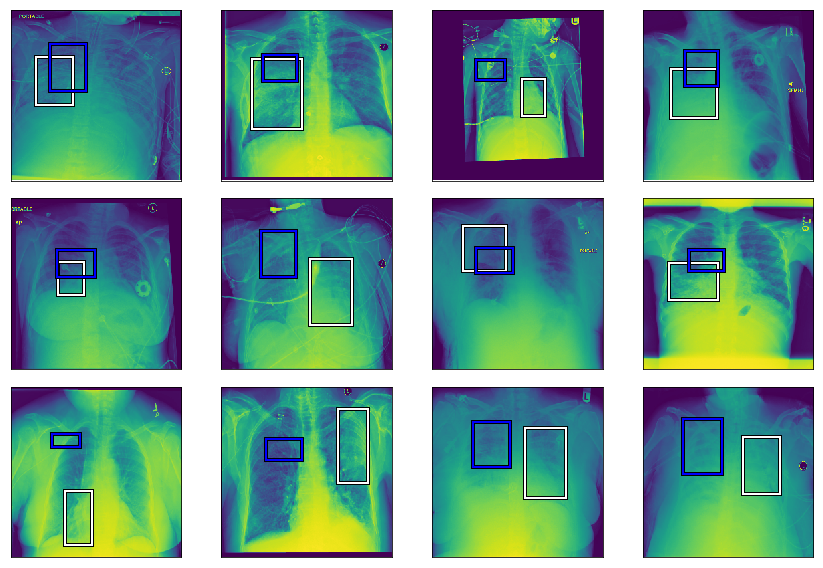

In [911]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ax = show_img(np.squeeze(x[i]), ax=ax)
    draw_rect(ax, y[i])
    draw_rect(ax, preds[i], color='blue')
plt.tight_layout()

In [912]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

Epoch 1/5
77/77 [==============================] - 27s 354ms/step - loss: 1731.2476 - val_loss: 1519.1321
Epoch 2/5
77/77 [==============================] - 26s 343ms/step - loss: 1441.7484 - val_loss: 1430.2717
Epoch 3/5
77/77 [==============================] - 26s 344ms/step - loss: 1349.5180 - val_loss: 1513.2575
Epoch 4/5
77/77 [==============================] - 27s 344ms/step - loss: 1349.2610 - val_loss: 1431.6199
Epoch 5/5
77/77 [==============================] - 26s 343ms/step - loss: 1329.3545 - val_loss: 1462.5634


In [919]:
x,y = next(valid_dl)

In [920]:
preds = model.predict(x)

The white boxes are the ground truth and the blue boxes are our predictions

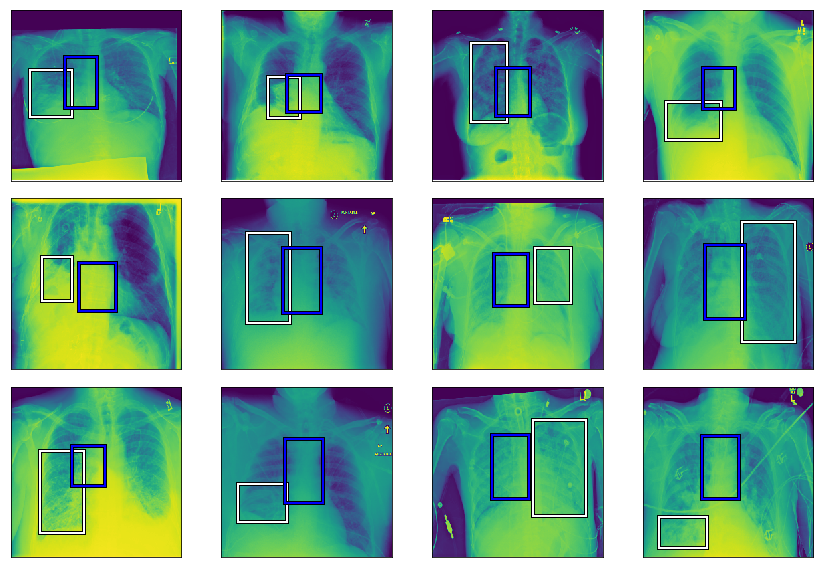

In [921]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ax = show_img(np.squeeze(x[i]), ax=ax)
    draw_rect(ax, y[i])
    draw_rect(ax, preds[i], color='blue')
plt.tight_layout()

#### More complex/advanced network architecture

In [499]:
from keras_resnet.models import ResNet34

In [534]:
input_layer = Input((256,256,1))
model = ResNet34(inputs=input_layer, include_top=False)

In [535]:
input_layer = model.input
middle_layer = model.layers[-1].output
flat = Flatten()(middle_layer)
out = Dense(4, activation='linear')(flat)

In [536]:
model = Model(inputs=model.input, outputs= [out])

In [538]:
model.compile('adam', mean_squared_error_no_nan, metrics=['acc'])

In [539]:
train_targets = np.asarray(train_df[[3,4,5,6]]) #x,y,width,height
valid_targets = np.asarray(valid_df[[3,4,5,6]]) #x,y,width,height

In [540]:
train_targets[:,:4] = train_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024
valid_targets[:,:4] = valid_targets[:,:4]//4 #resize targets since image size is 256 instead of 1024

And now training!

In [547]:
bs = 64
epochs = 5
train_N = len(train_df) #dataset size
valid_N = len(valid_df)
train_dl = CustomImageDataLoader(train_df[1], train_targets, bs=bs, tfm=tfm, shuffle=True)
valid_dl = CustomImageDataLoader(valid_df[1], valid_targets, bs=bs)

In [548]:
model.fit_generator(
    train_dl, steps_per_epoch=math.ceil(train_N/bs), 
    validation_data=valid_dl, validation_steps=math.ceil(valid_N/bs) ,
    epochs = epochs
)

Epoch 1/5
349/349 [==============================] - 134s 383ms/step - loss: nan - acc: 0.7221 - val_loss: 1636.3998 - val_acc: 0.2399
Epoch 2/5
349/349 [==============================] - 130s 372ms/step - loss: nan - acc: 0.8195 - val_loss: 2190.3697 - val_acc: 0.8918
Epoch 3/5
349/349 [==============================] - 130s 373ms/step - loss: nan - acc: 0.8036 - val_loss: 1626.8304 - val_acc: 0.6971
Epoch 4/5
349/349 [==============================] - 130s 373ms/step - loss: nan - acc: 0.8158 - val_loss: 1434.6176 - val_acc: 0.7023
Epoch 5/5
349/349 [==============================] - 130s 372ms/step - loss: 1522.4023 - acc: 0.7133 - val_loss: 1463.1646 - val_acc: 0.4897


In [553]:
x,y = next(valid_dl)

In [554]:
preds = model.predict(x)

In [555]:
box_idx=np.where(np.all(np.isnan(y),axis=-1)==False)

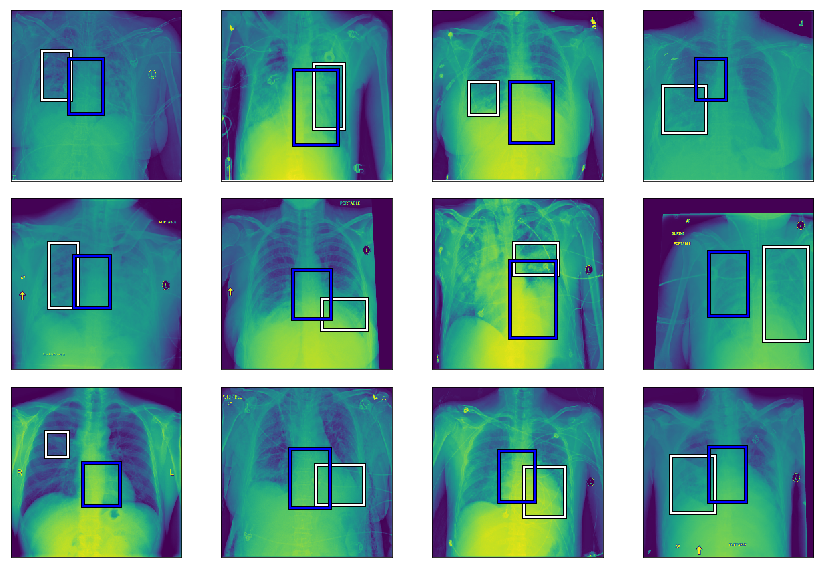

In [556]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ax = show_img(np.squeeze(x[box_idx][i]), ax=ax)
    draw_rect(ax, y[box_idx][i])
    draw_rect(ax, preds[box_idx][i], color='blue')
plt.tight_layout()

### Create Submission